# Professions: comparison

In the following notebook we're going to compare all the approaches we developed and test them on a small amount of professions for which we have precise statics about. We will use both FastText's and Gonen's embeddings.

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load FastText's emdeddings
E_ft =  WordEmbedding('../embedding/fast-text/cc.it.300.reduced.vec', 'ft')

*** Reading data from ../embedding/fast-text/cc.it.300.reduced.vec
(485, 300)
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica
485 words of dimension 300 : questo, sua, suo, prima, ..., supportivo, calzolaia, supportiva, agrotecnica


### Step 2: working whit FastText's embeddings

#### Step 2.1: vector difference

In [3]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

#### Step 2.2: PCA

In [4]:
# list of pairs to define gender
'''
gender_pairs = [['lei','lui'],
                ['donna','uomo'], 
                ['madre','padre'],
                ['moglie','marito'],
                ['sorella','fratello'],
                ['femmina','maschio']]
'''

gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [5]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [6]:
print("Singular values:")
print(sv)

Singular values:
[9.5309240e-01 5.3566736e-01 3.7772956e-01 3.4538972e-01 2.9901835e-01
 2.4023318e-01 5.8411594e-08 4.6098762e-08 4.3273410e-08 4.1712632e-08]


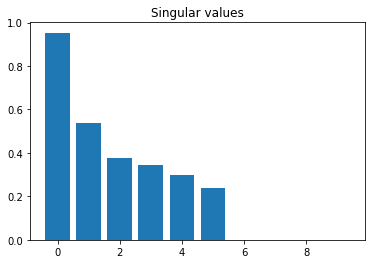

In [7]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [8]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

#### Step 2.3: pseudo-LDA

In [9]:
'''
S_word = [['lei','lui'],
          ['donna','uomo'],
          ['madre','padre'],
          ['moglie','marito'],
          ['sorella','fratello'],
          ['femmina','maschio']]
'''

S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [10]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [11]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [12]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

#### Step 2.4: compute projections

##### Ungendered professions

In [13]:
# read professions
prof_ung_truth = db.read('professions_ung.csv', 'truth')

In [14]:
# compute projection of each profession on g_diff
proj_ung_g_diff = db.prof_proj(E_ft, prof_ung_truth, g_diff, 'istat')

# compute projection of each profession on g_pca_0
proj_ung_g_pca_0 = db.prof_proj(E_ft, prof_ung_truth, g_pca_0, 'istat')

# compute projection of each profession on g_pca_01
proj_ung_g_pca_01 = db.prof_proj(E_ft, prof_ung_truth, g_pca_01, 'istat')

# compute projection of each profession on g_e
proj_ung_g_e = db.prof_proj(E_ft, prof_ung_truth, g_e, 'istat')

In [15]:
# print results
ung_col0 = [] # pandas columns
ung_col1 = []
ung_col2 = []
ung_col3 = []
ung_col4 = []
ung_col5 = []
ung_col6 = []

for i in range(len(proj_ung_g_diff)):
    ung_col0.append(proj_ung_g_diff[i][0]) # profession
    ung_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    ung_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    ung_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    ung_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    ung_col5.append(proj_ung_g_diff[i][2]) # %male
    ung_col6.append(proj_ung_g_diff[i][3]) # %female

    
ung_data = {'Profession':ung_col0, 
           'Proj g_diff':ung_col1,
           'Proj g_pca_0':ung_col2, 
           'Proj g_pca_01':ung_col3,
           'Prog g_e':ung_col4,
           '% male':ung_col5, 
           '% female':ung_col6}
ung_table = pd.DataFrame(ung_data)
ung_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% male,% female
0,camionista,0.027856,0.102896,0.050494,0.065189,96.9,3.1
1,elettricista,0.073085,0.122825,0.115196,0.019939,96.8,3.2
2,ingegnere,0.043748,0.217653,0.167188,0.026228,83.6,16.4
3,architetto,0.076696,0.183021,0.165500,0.059626,64.7,35.3
4,notaio,0.082010,0.171843,0.112616,0.022859,66.4,33.6
5,commercialista,0.024475,0.113249,0.061505,0.053153,68.2,31.8
6,giornalista,-0.048235,0.050688,-0.002423,-0.006167,54.7,45.3
7,insegnante,-0.103818,-0.055340,-0.070229,0.020056,17.3,82.7
8,barista,0.027839,0.052001,0.019284,0.062231,38.9,61.1
9,medico,-0.004724,0.135863,0.039559,-0.040868,56.3,43.7


In [16]:
#ung_table.to_csv('truth_ung_ft.csv', index=False)

In [17]:
# pearson correlation
r_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[0]
r_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[0]
r_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[0]
r_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[0]

p_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[1]
p_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[1]
p_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[1]
p_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[1]

In [18]:
pearson_data = {'g_diff':[r_g_diff,p_g_diff],
                'g_pca_0':[r_g_pca_0,p_g_pca_0],
                'g_pca_01':[r_g_pca_01,p_g_pca_01],
                'g_e':[r_g_e,p_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.810652,-0.79832,-0.796630,-0.431935
p,0.000140,0.00021,0.000221,0.094775


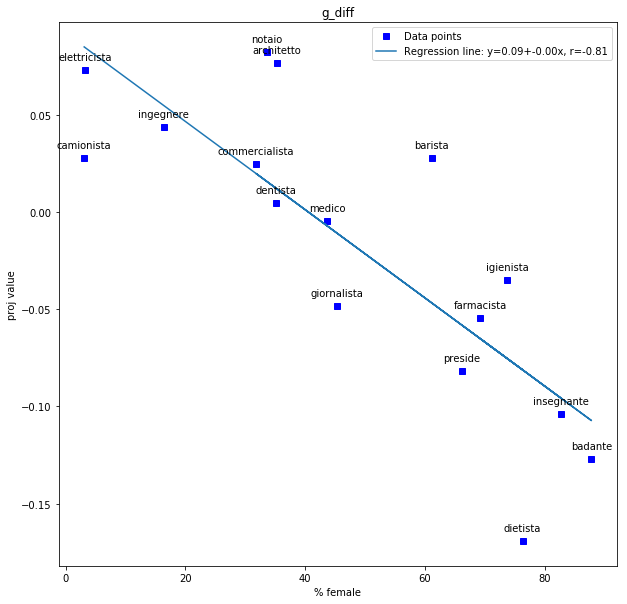

In [19]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_diff')

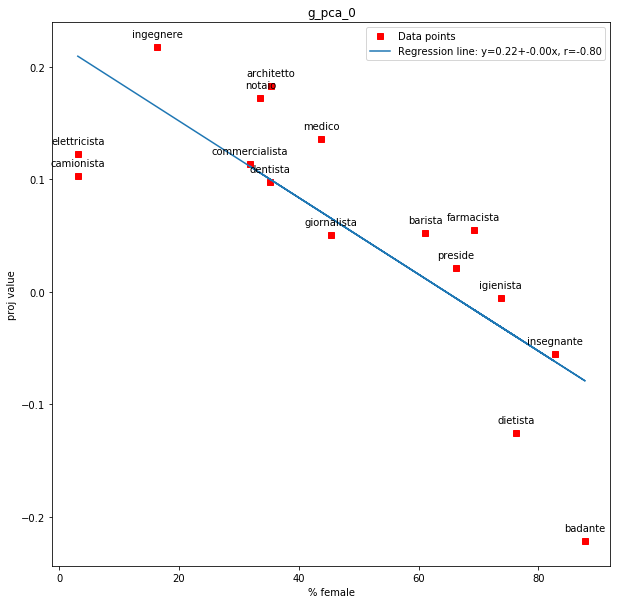

In [20]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_pca_0')

##### Gendered professions

In [21]:
# read professions
prof_gen_truth = db.read('professions_gen.csv', 'truth-mf')

In [22]:
# compute projection of each profession on g_diff
proj_gen_g_diff = db.prof_proj(E_ft, prof_gen_truth, g_diff, 'istat-mf')

# compute projection of each profession on g_pca_0
proj_gen_g_pca_0 = db.prof_proj(E_ft, prof_gen_truth, g_pca_0, 'istat-mf')

# compute projection of each profession on g_pca_01
proj_gen_g_pca_01 = db.prof_proj(E_ft, prof_gen_truth, g_pca_01, 'istat-mf')

# compute projection of each profession on g_e
proj_gen_g_e = db.prof_proj(E_ft, prof_gen_truth, g_e, 'istat-mf')

In [23]:
# print results
gen_col0 = [] # pandas columns
gen_col1 = []
gen_col2 = []
gen_col3 = []
gen_col4 = []
gen_col5 = []
gen_col6 = []
gen_col7 = []
gen_col8 = []
gen_col9 = []
gen_col10 = []

for i in range(len(proj_gen_g_diff)):
    gen_col0.append(proj_gen_g_diff[i][0]) # male profession
    gen_col1.append(proj_gen_g_diff[i][1]) # male projection on g_diff
    gen_col2.append(proj_gen_g_pca_0[i][1]) # male projection on g_pca_0
    gen_col3.append(proj_gen_g_pca_01[i][1]) # male projection on g_pca_01
    gen_col4.append(np.real(proj_gen_g_e[i][1])) # male projection on g_e
    gen_col5.append(proj_gen_g_diff[i][2]) # female profession
    gen_col6.append(proj_gen_g_diff[i][3]) # female projection on g_diff
    gen_col7.append(proj_gen_g_pca_0[i][3]) # female projection on g_pca_0
    gen_col8.append(proj_gen_g_pca_01[i][3]) # female projection on g_pca_01
    gen_col9.append(np.real(proj_gen_g_e[i][3])) # female projection on g_e
    gen_col10.append(proj_gen_g_diff[i][4]) # %female
    
gen_data = {'Male profession':gen_col0, 
           'M-Proj g_diff':gen_col1,
           'M-Proj g_pca_0':gen_col2, 
           'M-Proj g_pca_01':gen_col3,
           'M-Prog g_e':gen_col4,
           'Female profession':gen_col5, 
           'F-Proj g_diff':gen_col6,
           'F-Proj g_pca_0':gen_col7, 
           'F-Proj g_pca_01':gen_col8,
           'F-Prog g_e':gen_col9,  
           '% female':gen_col10}

gen_table = pd.DataFrame(gen_data)
gen_table

,Male profession,M-Proj g_diff,M-Proj g_pca_0,M-Proj g_pca_01,M-Prog g_e,Female profession,F-Proj g_diff,F-Proj g_pca_0,F-Proj g_pca_01,F-Prog g_e,% female
0,calzolaio,0.106336,0.155676,0.117852,0.022520,calzolaia,-0.083221,-0.217826,-0.183558,-0.007811,8.0
1,biologo,0.066985,0.229635,0.178475,-0.050910,biologa,-0.263955,-0.272445,-0.288617,0.001746,76.0
2,avvocato,-0.053588,0.132720,0.056975,-0.010401,avvocatessa,-0.291315,-0.283173,-0.312245,0.060756,47.2
3,psicologo,0.068424,0.169177,0.117352,-0.015112,psicologa,-0.238524,-0.304119,-0.323389,0.005394,82.9
4,maestro,0.201372,0.312891,0.275900,0.023119,maestra,-0.244963,-0.301025,-0.313171,0.037129,96.4
5,professore,-0.029616,0.228402,0.129135,0.007852,professoressa,-0.323749,-0.292575,-0.333926,0.014332,71.9
6,cameriere,0.046219,0.097974,0.054632,0.046446,cameriera,-0.189663,-0.259899,-0.277246,0.015340,51.4
7,albergatore,0.081593,0.130638,0.134854,-0.004077,albergatrice,-0.200101,-0.274839,-0.248046,0.043339,50.6
8,infermiere,-0.044242,0.007298,-0.023620,0.044576,infermiera,-0.253701,-0.257126,-0.294478,0.042178,77.0
9,geologo,0.035964,0.187185,0.125979,-0.042255,geologa,-0.277250,-0.278603,-0.292457,0.024115,39.8


In [24]:
#gen_table.to_csv('truth_gen_ft.csv', index=False)

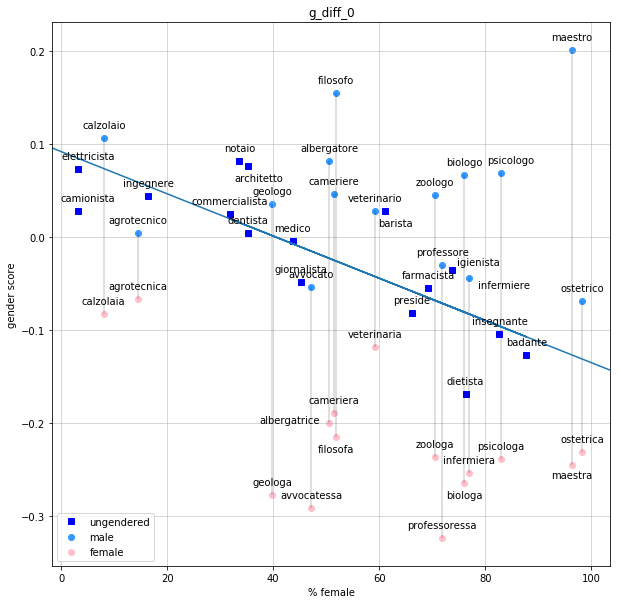

In [25]:
# correlation plot g_diff

# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)


for i in range(len(gen_col1)):
    ax.plot([gen_col10[i], gen_col10[i]], [gen_col1[i], gen_col6[i]], color='black', linewidth=0.25)

ax.scatter(gen_col10, gen_col1, c='#3399ff', label='male')
ax.scatter(gen_col10, gen_col6, c='pink', label='female')
    

xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_diff_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend(loc='lower left')

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='igienista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(27,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    

    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    if label=='infermiere':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(35,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='psicologo':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    if label=='albergatrice':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-40,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='filosofa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue     
        
    if label=='biologa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue            
        
    if label=='maestra':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_g_diff.pdf', bbox_inches='tight', format='pdf')

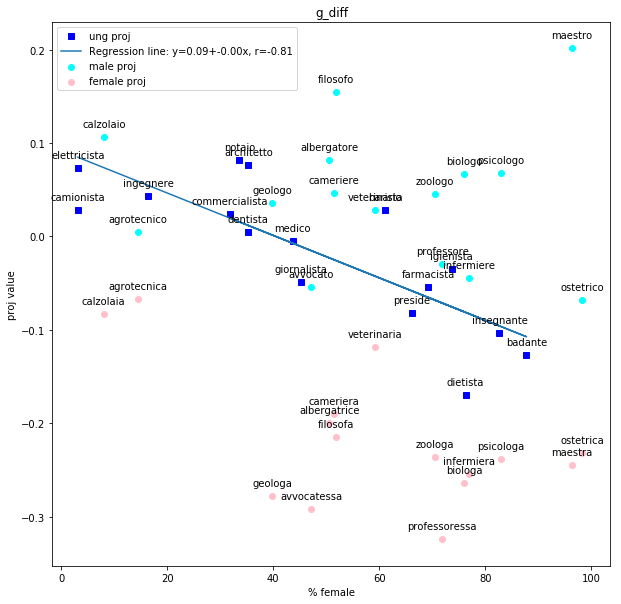

In [26]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col1, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col6, c='pink', label='female proj')
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_g_diff')

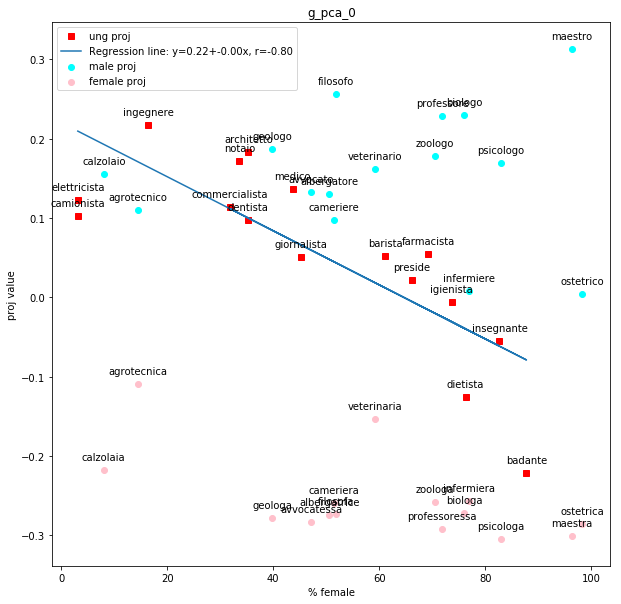

In [27]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col2, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col7, c='pink', label='female proj')
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.show()
#fig.savefig('plot/gen/ft_g_pca_0')

##### Ungendered + mean gendered professions

In [28]:
# print mean results
mean_col0 = []
mean_col1 = []
mean_col2 = []
mean_col3 = []
mean_col4 = []
mean_col5 = []

for i in range(len(proj_ung_g_diff)):
    mean_col0.append(proj_ung_g_diff[i][0]) # profession
    mean_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    mean_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    mean_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    mean_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    mean_col5.append(proj_ung_g_diff[i][3]) # %female
    
for i in range(len(proj_gen_g_diff)):
    mean_col0.append(proj_gen_g_diff[i][0]) # profession
    mean_col1.append((proj_gen_g_diff[i][1]+proj_gen_g_diff[i][3])/2) # mean projection on g_diff
    mean_col2.append((proj_gen_g_pca_0[i][1]+proj_gen_g_pca_0[i][3])/2) # mean projection on g_pca_0
    mean_col3.append((proj_gen_g_pca_01[i][1]+proj_gen_g_pca_01[i][3])/2) # mean projection on g_pca_01
    mean_col4.append((np.real(proj_gen_g_e[i][1])+np.real(proj_gen_g_e[i][3]))/2) # mean projection on g_e
    mean_col5.append(proj_gen_g_diff[i][4]) # %female
    
mean_data = {'Profession':mean_col0, 
           'Proj g_diff':mean_col1,
           'Proj g_pca_0':mean_col2, 
           'Proj g_pca_01':mean_col3,
           'Prog g_e':mean_col4, 
           '% female':mean_col5}

mean_table = pd.DataFrame(mean_data)
mean_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% female
0,camionista,0.027856,0.102896,0.050494,0.065189,3.1
1,elettricista,0.073085,0.122825,0.115196,0.019939,3.2
2,ingegnere,0.043748,0.217653,0.167188,0.026228,16.4
3,architetto,0.076696,0.183021,0.165500,0.059626,35.3
4,notaio,0.082010,0.171843,0.112616,0.022859,33.6
5,commercialista,0.024475,0.113249,0.061505,0.053153,31.8
6,giornalista,-0.048235,0.050688,-0.002423,-0.006167,45.3
7,insegnante,-0.103818,-0.055340,-0.070229,0.020056,82.7
8,barista,0.027839,0.052001,0.019284,0.062231,61.1
9,medico,-0.004724,0.135863,0.039559,-0.040868,43.7


In [29]:
# pearson correlation
r_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[0]
r_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[0]
r_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[0]
r_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[0]

p_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[1]
p_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[1]
p_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[1]
p_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[1]

In [30]:
pearson_data = {'g_diff':[r_mean_g_diff,p_mean_g_diff],
                'g_pca_0':[r_mean_g_pca_0,p_mean_g_pca_0],
                'g_pca_01':[r_mean_g_pca_01,p_mean_g_pca_01],
                'g_e':[r_mean_g_e,p_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.663815,-0.633884,-0.671989,-0.191416
p,0.000047,0.000129,0.000035,0.302289


In [31]:
trad = {
 'camionista':'truck driver',
 'elettricista':'electrician',
 'ingegnere':'engineer',
 'architetto':'architect',
 'notaio':'notary',
 'commercialista':'accountant',
 'giornalista':'journalist',
 'veterinario':'veterinary',
 'insegnante':'teacher',
 'barista':'barman',
 'medico':'doctor',
 'dentista':'dentist',
 'badante':'caregiver',
 'farmacista':'pharmacist',
 'dietista':'dietician',
 'igienista':'hygienist',
 'preside':'principal',
 'calzolaio':'cobbler',
 'biologo':'biologist',
 'avvocato':'lawyer',
 'psicologo':'psychologist',
 'maestro':'teacher',
 'professore':'professor',
 'cameriere':'waiter',
 'albergatore':'hotelier',
 'infermiere':'nurse',
 'geologo':'geologist',
 'zoologo':'zoologist',
 'filosofo':'philosopher',
 'ostetrico':'obstetrician',
 'agrotecnico':'agronomist'
}

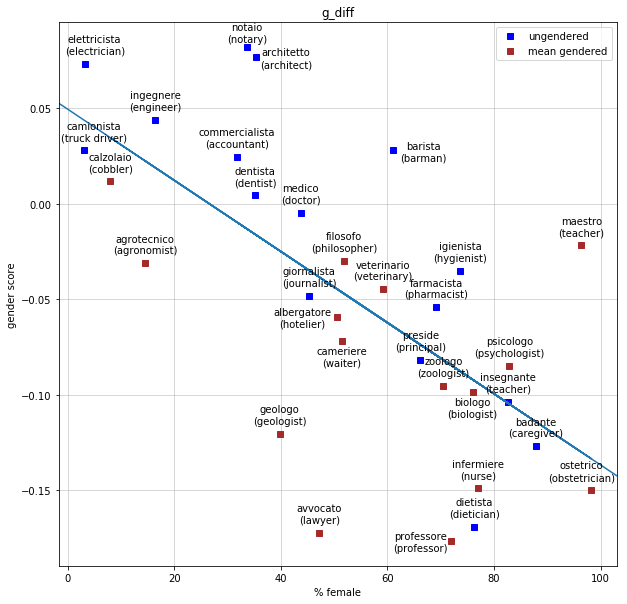

In [32]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ungendered')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean gendered')
#ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i, label in enumerate(mean_col0):
    if label=='notaio':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='veterinario':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='cameriere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='biologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='elettricista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='camionista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='ostetrico':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='albergatore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label+'\n('+trad[label]+')', # this is the text
                     (mean_col5[i], mean_col1[i]), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_g_diff')

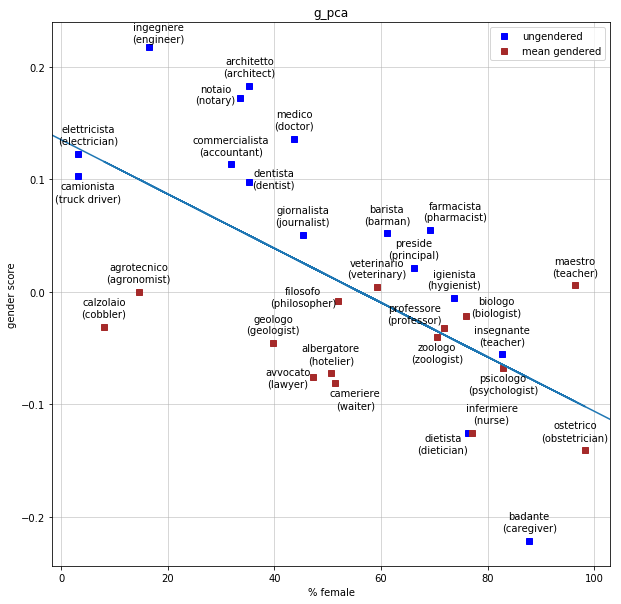

In [33]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(mean_col5[:16], mean_col2[:16], linewidth=0, marker='s', color='blue', label='ungendered')
ax.plot(mean_col5[16:], mean_col2[16:], linewidth=0, marker='s', color='brown', label='mean gendered')
#ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_pca')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i, label in enumerate(mean_col0):
    if label=='camionista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    
        
    if label=='elettricista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    
        
    if label=='ingegnere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    

    if label=='notaio':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue   

    if label=='dentista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='farmacista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='avvocato':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='cameriere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='albergatore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='infermiere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dietista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='zoologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='biologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  

    if label=='psicologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='ostetrico':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 

    if label=='filosofo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_g_pca_0')

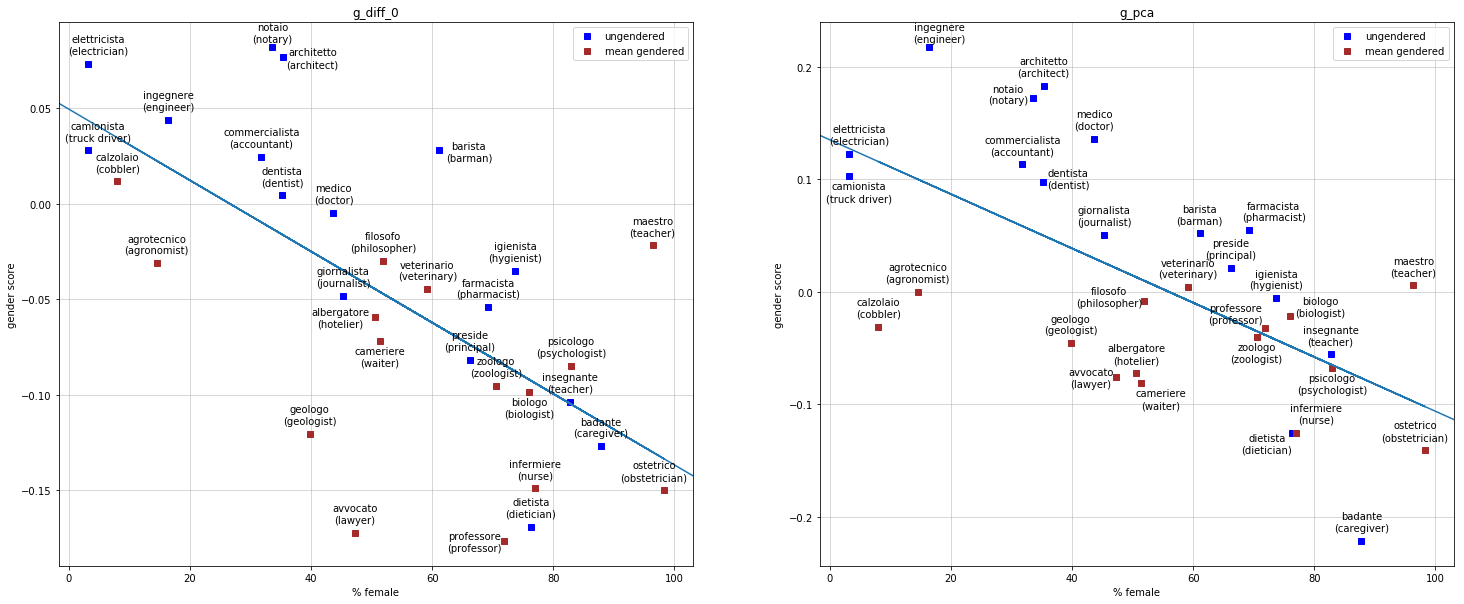

In [34]:
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(121)
ax.grid(linewidth=0.5)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ungendered')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean gendered')
#ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_diff_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i, label in enumerate(mean_col0):
    if label=='notaio':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='veterinario':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='cameriere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='biologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='elettricista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='camionista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='ostetrico':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='albergatore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label+'\n('+trad[label]+')', # this is the text
                     (mean_col5[i], mean_col1[i]), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    
    
    
    
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col2)
line = f'regression line: y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'
   
ax = fig.add_subplot(122)
ax.grid(linewidth=0.5)
ax.plot(mean_col5[:16], mean_col2[:16], linewidth=0, marker='s', color='blue', label='ungendered')
ax.plot(mean_col5[16:], mean_col2[16:], linewidth=0, marker='s', color='brown', label='mean gendered')
#ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_pca')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i, label in enumerate(mean_col0):
    if label=='camionista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    
        
    if label=='elettricista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    
        
    if label=='ingegnere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    

    if label=='notaio':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue   

    if label=='dentista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='farmacista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(25,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='avvocato':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='cameriere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='albergatore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='infermiere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dietista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='zoologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='biologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  

    if label=='psicologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='ostetrico':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 

    if label=='filosofo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()
#fig.savefig('ft_g_diff_g_pca')
#fig.savefig('ft_g_diff_g_pca.pdf', bbox_inches='tight', format='pdf')

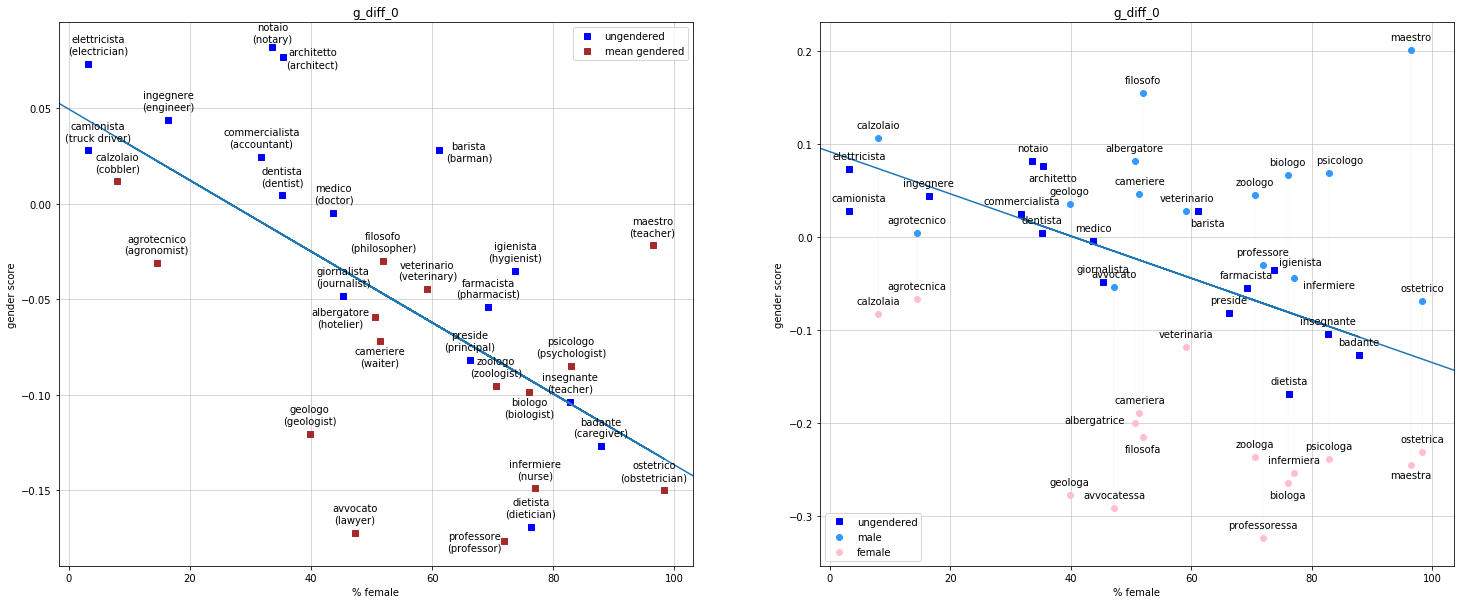

In [35]:
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(121)
ax.grid(linewidth=0.5)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ungendered')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean gendered')
#ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
xlims = plt.xlim()
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_diff_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend()

for i, label in enumerate(mean_col0):
    if label=='notaio':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='veterinario':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='cameriere':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='biologo':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='elettricista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='camionista':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='ostetrico':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='albergatore':
        plt.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label+'\n('+trad[label]+')', # this is the text
                     (mean_col5[i], mean_col1[i]), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    
    
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'
  
ax = fig.add_subplot(122)
ax.grid(linewidth=0.5)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)


for i in range(len(gen_col1)):
    ax.plot([gen_col10[i], gen_col10[i]], [gen_col1[i], gen_col6[i]], color='grey', linewidth=0.05, zorder=1)

ax.scatter(gen_col10, gen_col1, c='#3399ff', label='male', zorder=2)
ax.scatter(gen_col10, gen_col6, c='pink', label='female', zorder=2)
    

xlims = plt.xlim()
x = [i for i in ung_col6]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x))
plt.xlim(xlims)
ax.set_title('g_diff_0')
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.legend(loc='lower left')

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='igienista':
        plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(27,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue    

    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    if label=='infermiere':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(35,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='psicologo':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    if label=='albergatrice':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-40,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='filosofa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue     
        
    if label=='biologa':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue            
        
    if label=='maestra':
        plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center    
    


plt.show()
#fig.savefig('ft_g_diff_ung_gen.pdf', bbox_inches='tight', format='pdf')

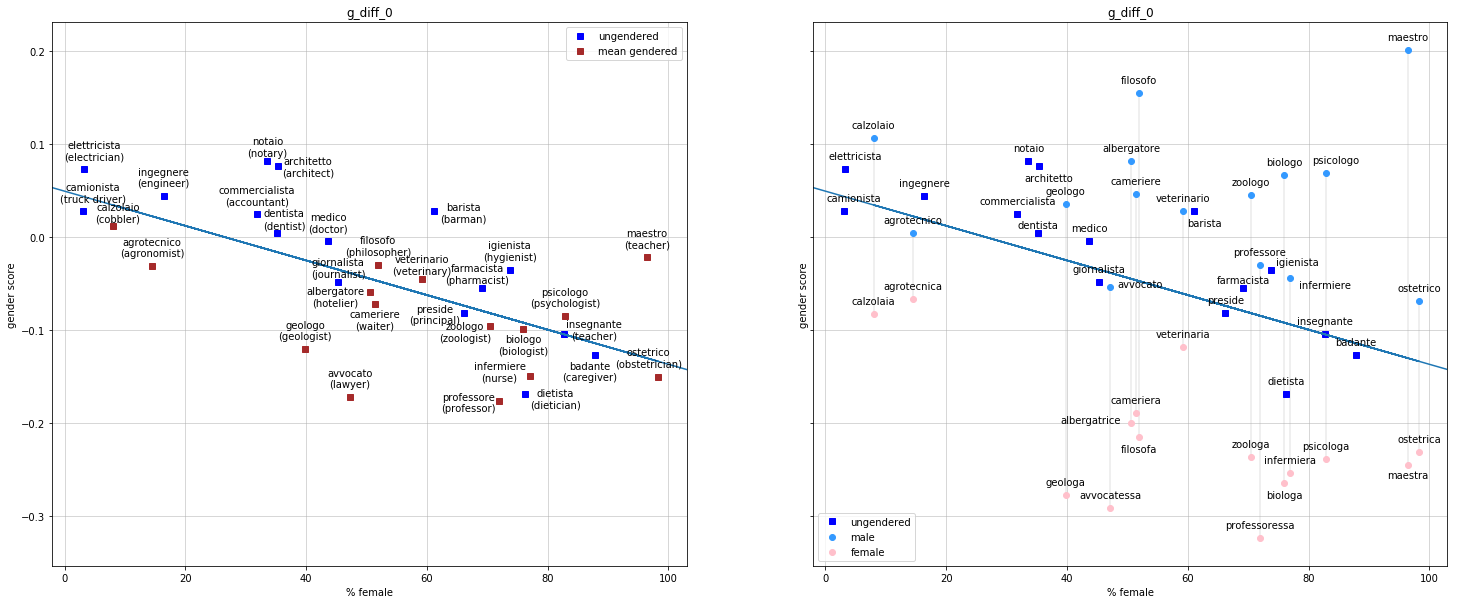

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,10))


slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

#fig = plt.figure(figsize=(25,10))    
#ax = fig.add_subplot(121)
ax1.grid(linewidth=0.5)
ax1.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ungendered')
ax1.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean gendered')
#ax1.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5))

xlims = [-2, 103]
x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax1.plot(np.array(x), intercept + slope * np.array(x))
ax1.set_xlim(xlims[0], xlims[1])

ax1.set_title('g_diff_0')
ax1.set_xlabel('% female')
ax1.set_ylabel('gender score')
ax1.legend()

for i, label in enumerate(mean_col0):
    if label=='notaio':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='insegnante':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue     
        
    if label=='zoologo':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-25,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='architetto':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='veterinario':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='cameriere':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dentista':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(7,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='dietista':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='biologo':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='professore':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='elettricista':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='camionista':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='ostetrico':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='albergatore':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-35,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='calzolaio':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(5,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='giornalista':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='preside':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='infermiere':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-30,-5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='farmacista':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-5,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue

    if label=='badante':
        ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-5,-25), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    ax1.annotate(label+'\n('+trad[label]+')', # this is the text
                     (mean_col5[i], mean_col1[i]), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    
    
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'
  
#ax = fig.add_subplot(122)
ax2.grid(linewidth=0.5)
ax2.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax2.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5))


for i in range(len(gen_col1)):
    ax2.plot([gen_col10[i], gen_col10[i]], [gen_col1[i], gen_col6[i]], color='grey', linewidth=0.25, zorder=1)

ax2.scatter(gen_col10, gen_col1, c='#3399ff', label='male', zorder=2)
ax2.scatter(gen_col10, gen_col6, c='pink', label='female', zorder=2)

x = [i for i in mean_col5]
x.insert(0, xlims[0])
x.append(xlims[1])
ax2.plot(np.array(x), intercept + slope * np.array(x))
ax2.set_xlim(xlims[0], xlims[1])

ax2.set_title('g_diff_0')
ax2.set_xlabel('% female')
ax2.set_ylabel('gender score')
ax2.legend(loc='lower left')

for i, label in enumerate(ung_col0):
    if label=='elettricista' or label=='camionista':
        ax2.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='architetto':
        ax2.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='barista':
        ax2.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='igienista':
        ax2.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(27,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    if label=='dentista':
        ax2.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    if label=='farmacista':
        ax2.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue 
        
    ax2.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    if label=='infermiere':
        ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(35,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='psicologo':
        ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='avvocato':
        ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(30,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    if label=='albergatrice':
        ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-40,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue
        
    if label=='filosofa':
        ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue     
        
    if label=='biologa':
        ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue            
        
    if label=='maestra':
        ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-13), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
        continue  
        
    ax2.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center  
    


plt.show()
#fig.savefig('ft_g_diff_ung_gen_sharey.pdf', bbox_inches='tight', format='pdf')

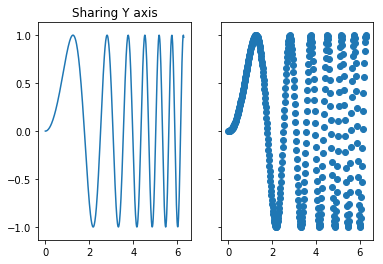

In [46]:
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)


# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)
